In [ ]:
!pip install PyMySQL
# https://github.com/PyMySQL/PyMySQL/
!pip install pandas

Load Database

In [ ]:
import pymysql.cursors
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [ ]:
def connect():
    # database credentials
    host = 'den1.mysql6.gear.host'
    db = 'situation'
    usr = 'situation'
    # pwd = input()
    pwd = input()

    # connect to the database
    try:
        return pymysql.connect(host=host, user=usr, password=pwd, database=db,
            cursorclass=pymysql.cursors.DictCursor)
    except pymysql.Error as err:
        print("error %d: %s" %(err.args[0], err.args[1]))
        return ""

In [ ]:
def query_table(table_name):
    sql = f"SELECT * FROM {table_name};"

    # connect to database
    db_connection = connect()

    # check connection
    if not (type(db_connection) == str):
        # execute query and fetch results
        with db_connection.cursor() as cursor:
            cursor.execute(sql)
            result = cursor.fetchall()
        return result
    else:
        return []

In [ ]:
# Call the function to query the table
dataset = query_table('t20_chemicalsensor_data')

# Print out the results
for row in dataset:
    print(row)

aichem567.
{'SensorID': 1, 'Timestamp': datetime.datetime(2024, 1, 1, 0, 0), 'SensorValue': 56.7641, 'Temperature': 20.0, 'Humidity': 60.0, 'DegradationLevel': 0.0}
{'SensorID': 1, 'Timestamp': datetime.datetime(2024, 1, 2, 0, 0), 'SensorValue': 60.1641, 'Temperature': 20.3917, 'Humidity': 59.0499, 'DegradationLevel': 0.012346}
{'SensorID': 1, 'Timestamp': datetime.datetime(2024, 1, 3, 0, 0), 'SensorValue': 62.309, 'Temperature': 21.5564, 'Humidity': 56.2088, 'DegradationLevel': 0.024691}
{'SensorID': 1, 'Timestamp': datetime.datetime(2024, 1, 4, 0, 0), 'SensorValue': 64.0033, 'Temperature': 23.419, 'Humidity': 51.6724, 'DegradationLevel': 0.037037}
{'SensorID': 1, 'Timestamp': datetime.datetime(2024, 1, 5, 0, 0), 'SensorValue': 68.76, 'Temperature': 25.7989, 'Humidity': 46.1243, 'DegradationLevel': 0.049383}
{'SensorID': 1, 'Timestamp': datetime.datetime(2024, 1, 6, 0, 0), 'SensorValue': 69.6223, 'Temperature': 28.505, 'Humidity': 40.3306, 'DegradationLevel': 0.061728}
{'SensorID': 1,

Data Processing:

In [ ]:
!pip install numpy


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(dataset)

# Convert Timestamp to datetime if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by SensorID and Timestamp
df = df.sort_values(by=['SensorID', 'Timestamp'])

# Normalize the data
scaler = MinMaxScaler()
df[['SensorValue', 'Temperature', 'Humidity', 'DegradationLevel']] = scaler.fit_transform(df[['SensorValue', 'Temperature', 'Humidity', 'DegradationLevel']])

# Creating sequences for CNN
def create_sequences(data, sequence_length=10):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length][-1]  # Predicting the last element in each sequence (DegradationLevel)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 10
sensor_data = df[['SensorValue', 'Temperature', 'Humidity', 'DegradationLevel']].values

X, y = create_sequences(sensor_data, sequence_length)

# Splitting data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Training data shape: (18, 10, 4), Training labels shape: (18,)
Test data shape: (5, 10, 4), Test labels shape: (5,)


Building the CNN Model

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [ ]:
from tensorflow.keras.layers import LSTM

# Building a CNN model with LSTM layers
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Predicting a single continuous value (DegradationLevel)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 9, 64)             576       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 128)            16512     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 50)                35800     
                                                                 
 dense_4 (Dense)             (None, 50)               

Traning the Model

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.2682 - val_loss: 0.5865
Epoch 2/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2533 - val_loss: 0.5538
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2339 - val_loss: 0.5232
Epoch 4/50
1/1 [==============================] - 0s 57ms/step - loss: 0.2133 - val_loss: 0.4881
Epoch 5/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1942 - val_loss: 0.4511
Epoch 6/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1775 - val_loss: 0.4129
Epoch 7/50
1/1 [==============================] - 0s 32ms/step - loss: 0.1471 - val_loss: 0.3729
Epoch 8/50
1/1 [==============================] - 0s 49ms/step - loss: 0.1363 - val_loss: 0.3306
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 0.1153 - val_loss: 0.2865
Epoch 10/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0931 - val_loss: 0.2403
Epoch 11/50
1/1 [==============

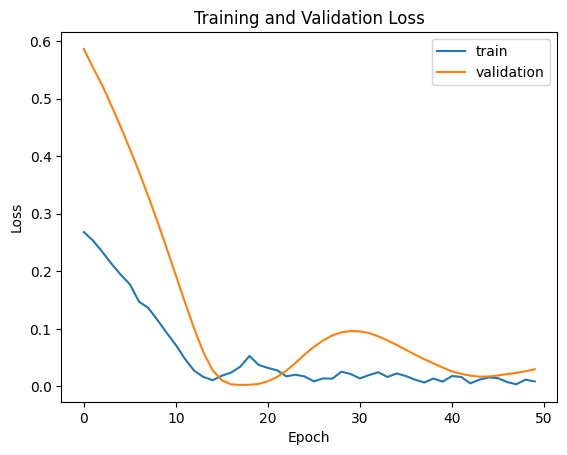

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plotting training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Evaluate the Model

1/1 [==============================] - 0s 23ms/step - loss: 0.1253
Test Loss: 0.1252642571926117
1/1 [==============================] - 0s 195ms/step


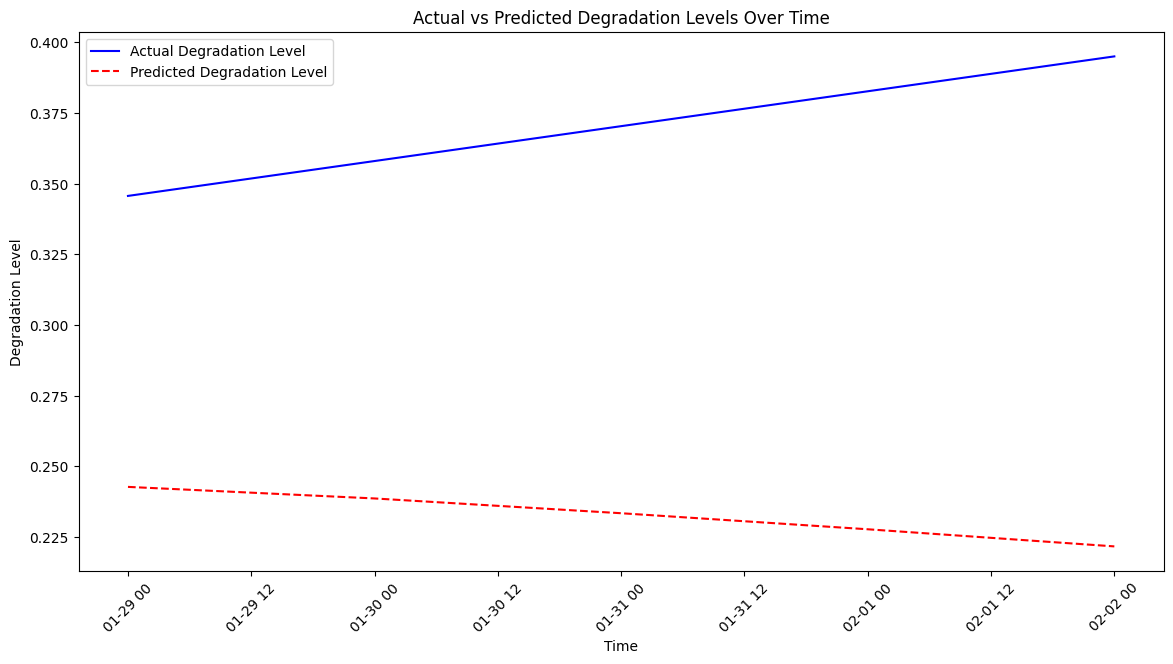

In [ ]:
# Evaluating the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Making predictions
y_pred = model.predict(X_test)

# Extract timestamps for test set for plotting
test_indices = df.index[-len(y_test):]
test_timestamps = df.loc[test_indices, 'Timestamp']

# Rescale the predictions and actual values back to original scale
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 3)), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), 3)), y_pred], axis=1))[:, -1]

# Comparing predictions with actual values
plt.figure(figsize=(14, 7))
plt.plot(test_timestamps, y_test_rescaled, label='Actual Degradation Level', color='blue')
plt.plot(test_timestamps, y_pred_rescaled, label='Predicted Degradation Level', color='red', linestyle='dashed')
plt.xlabel('Time')  # Adding x-axis label as Time
plt.ylabel('Degradation Level')  # Adding y-axis label
plt.legend()
plt.title('Actual vs Predicted Degradation Levels Over Time')
plt.xticks(rotation=45)  # Rotate timestamps for better readability
plt.show()